## 1. Text Classification / Full mask

In [ ]:
!pip install transformers
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


def tokenize(example):
    return tokenizer(example["review"], truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

def predict_sentiment(texts, batch_size=128, max_length=512):
    all_preds = []
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
    batch = texts[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True,
                       max_length=max_length).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_probs.extend(probs.cpu().numpy())

    return all_preds, all_probs

### DistilBert

In [ ]:
df_all = pd.read_csv('/content/IMDB Dataset.csv')

df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all["label"] = df_all["sentiment"].map({"negative": 0, "positive": 1})

train_df, val_df = train_test_split(df_all, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_df[["review", "label"]])
val_dataset = Dataset.from_pandas(val_df[["review", "label"]])

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["review"])
val_dataset = val_dataset.remove_columns(["review"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")


model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english", num_labels=2
)

training_args = TrainingArguments(
    dataloader_num_workers=2,
    report_to=[],
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    num_train_epochs=2,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=64,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    #use_cpu=True,
    fp16=True,
)

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


model.save_pretrained("./finetuned-distilbert-sentiment")
tokenizer.save_pretrained("./finetuned-distilbert-sentiment")

/tmp/ipython-input-11-1073331516.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.239200,0.183361,0.929200
400,0.190200,0.179660,0.934000
600,0.082400,0.188229,0.935600
800,0.100100,0.175690,0.937800


('./finetuned-distilbert-sentiment/tokenizer_config.json',
 './finetuned-distilbert-sentiment/special_tokens_map.json',
 './finetuned-distilbert-sentiment/vocab.txt',
 './finetuned-distilbert-sentiment/added_tokens.json',
 './finetuned-distilbert-sentiment/tokenizer.json')

### Roberta

In [ ]:
df_all = pd.read_csv('/content/IMDB Dataset.csv')

df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all["label"] = df_all["sentiment"].map({"negative": 0, "positive": 1})

train_df, val_df = train_test_split(df_all, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_df[["review", "label"]])
val_dataset = Dataset.from_pandas(val_df[["review", "label"]])

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["review"])
val_dataset = val_dataset.remove_columns(["review"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")


model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    report_to=[],
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=416,
    save_strategy="steps",
    save_steps=416,
    num_train_epochs=2,
    per_device_train_batch_size=54,
    per_device_eval_batch_size=54,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    dataloader_num_workers=2,
)

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


model.save_pretrained("./finetuned-roberta-sentiment")
tokenizer.save_pretrained("./finetuned-roberta-sentiment")

/tmp/ipython-input-24-2709801614.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
416,0.195100,0.160606,0.938400
832,0.154700,0.141089,0.949600
1248,0.083000,0.181984,0.939600
1664,0.079700,0.152651,0.953600


('./finetuned-roberta-sentiment/tokenizer_config.json',
 './finetuned-roberta-sentiment/special_tokens_map.json',
 './finetuned-roberta-sentiment/vocab.json',
 './finetuned-roberta-sentiment/merges.txt',
 './finetuned-roberta-sentiment/added_tokens.json',
 './finetuned-roberta-sentiment/tokenizer.json')

In [ ]:
# @title Проверяем Roberta

df_all = pd.read_csv('/content/IMDB Dataset.csv')

df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all["label"] = df_all["sentiment"].map({"negative": 0, "positive": 1})

model_path = "/content/finetune-roberta-sentiment"
tokenizer = RobertaTokenizerFast.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

train_df, val_df = train_test_split(df_all, test_size=0.1, random_state=42)

preds, probs = predict_sentiment(val_df["review"].tolist())

true_labels = val_df["label"].tolist()
acc = accuracy_score(true_labels, preds)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(true_labels, preds, target_names=["negative", "positive"]))

Predicting: 100%|██████████| 40/40 [2:31:57<00:00, 227.94s/it]


✅ Accuracy: 0.9536
              precision    recall  f1-score   support

    negative       0.96      0.95      0.95      2512
    positive       0.95      0.96      0.95      2488

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

import os

# === Настройки CUDA ===
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Данные ===
df = pd.read_csv("/content/IMDB Dataset.csv")
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

# === Токенизатор ===
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[CLS]"]
if not os.path.exists("my_tokenizer.json"):
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=8000, special_tokens=SPECIAL_TOKENS)
    tokenizer.train_from_iterator(train_df["review"].tolist(), trainer)
    tokenizer.save("my_tokenizer.json")

tokenizer = Tokenizer.from_file("my_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

# === Гиперпараметры ===
MAX_LEN = 512
BATCH_SIZE = 128
EPOCHS = 4
D_MODEL = 384
N_HEADS = 8
N_LAYERS = 4

# === Датасет ===
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        encoded = tokenizer.encode(self.texts[idx])
        input_ids = [tokenizer.token_to_id("[CLS]")] + encoded.ids[:MAX_LEN - 1]
        attention_mask = [1] * len(input_ids)
        pad_len = MAX_LEN - len(input_ids)
        input_ids += [tokenizer.token_to_id("[PAD]")] * pad_len
        attention_mask += [0] * pad_len

        return {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_mask),
            "label": torch.tensor(self.labels[idx]),
        }

    def __len__(self):
        return len(self.texts)

train_dataset = IMDBDataset(train_df["review"].tolist(), train_df["label"].tolist())
val_dataset = IMDBDataset(val_df["review"].tolist(), val_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# === Модель ===
class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=0.2,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.2)
        self.cls_fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        attn_mask = ~attention_mask.bool()
        x = self.transformer(x, src_key_padding_mask=attn_mask)
        cls_token = x[:, 0]
        out = self.dropout(self.norm(cls_token))
        return self.cls_fc(out)

# === Инициализация ===
model = MiniTransformer(vocab_size, D_MODEL, N_HEADS, N_LAYERS, 2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# === Обучение ===
for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(loop):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # === Каждые 300 шагов: mini-validation ===
        if (step + 1) % 300 == 0:
            model.eval()
            with torch.no_grad():
                val_preds, val_labels = [], []
                for val_batch in list(val_loader)[:10]:  # Быстрая проверка
                    ids = val_batch["input_ids"].to(device)
                    mask = val_batch["attention_mask"].to(device)
                    lbls = val_batch["label"].to(device)
                    with torch.cuda.amp.autocast():
                        outputs = model(ids, mask)
                    preds = torch.argmax(outputs, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(lbls.cpu().numpy())
                val_acc = accuracy_score(val_labels, val_preds)
            loop.set_postfix(loss=loss.item(), val_acc=val_acc)
            model.train()

    # === Полная валидация после эпохи ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            lbls = batch["label"].to(device)
            with torch.cuda.amp.autocast():
                outputs = model(ids, mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    epoch_acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Epoch {epoch+1} Validation Accuracy: {epoch_acc:.4f}\n")

/tmp/ipython-input-5-646233910.py:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1:  80%|████████  | 299/372 [02:12<00:31,  2.28it/s]/tmp/ipython-input-5-646233910.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1:  81%|████████  | 300/372 [02:16<01:41,  1.42s/it, loss=0.493, val_acc=0.803]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██


✅ Epoch 1 Validation Accuracy: 0.8256



Epoch 2:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2:  80%|████████  | 299/372 [02:11<00:31,  2.29it/s]/tmp/ipython-input-5-646233910.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2:  81%|████████  | 300/372 [02:16<02:02,  1.70s/it, loss=0.362, val_acc=0.848]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2: 100%|██████████| 372/372 [02:47<00:00,  2.21it/s, loss=0.362, val_acc=0.848]
/tmp/ipython-input-5-646233910.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast(


✅ Epoch 2 Validation Accuracy: 0.8608



Epoch 3:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3:  80%|████████  | 299/372 [02:12<00:31,  2.28it/s]/tmp/ipython-input-5-646233910.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3:  81%|████████  | 300/372 [02:16<01:41,  1.41s/it, loss=0.28, val_acc=0.866]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3: 100%|██████████| 372/372 [02:47<00:00,  2.22it/s, loss=0.28, val_acc=0.866]
/tmp/ipython-input-5-646233910.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('c


✅ Epoch 3 Validation Accuracy: 0.8780



Epoch 4:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4:  80%|████████  | 299/372 [02:11<00:32,  2.27it/s]/tmp/ipython-input-5-646233910.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4:  81%|████████  | 300/372 [02:16<01:59,  1.66s/it, loss=0.297, val_acc=0.878]/tmp/ipython-input-5-646233910.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4: 100%|██████████| 372/372 [02:47<00:00,  2.22it/s, loss=0.297, val_acc=0.878]
/tmp/ipython-input-5-646233910.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast(


✅ Epoch 4 Validation Accuracy: 0.8732



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

import os

# === Настройки CUDA ===
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Данные ===
df = pd.read_csv("/content/IMDB Dataset.csv")
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

# === Токенизатор ===
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[CLS]"]
if not os.path.exists("my_tokenizer.json"):
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=16000, special_tokens=SPECIAL_TOKENS)
    tokenizer.train_from_iterator(train_df["review"].tolist(), trainer)
    tokenizer.save("my_tokenizer.json")

tokenizer = Tokenizer.from_file("my_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

# === Гиперпараметры ===
MAX_LEN = 512
BATCH_SIZE = 256
EPOCHS = 16
D_MODEL = 192
N_HEADS = 4
N_LAYERS = 2

# === Датасет ===
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        encoded = tokenizer.encode(self.texts[idx])
        input_ids = [tokenizer.token_to_id("[CLS]")] + encoded.ids[:MAX_LEN - 1]
        attention_mask = [1] * len(input_ids)
        pad_len = MAX_LEN - len(input_ids)
        input_ids += [tokenizer.token_to_id("[PAD]")] * pad_len
        attention_mask += [0] * pad_len

        return {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_mask),
            "label": torch.tensor(self.labels[idx]),
        }

    def __len__(self):
        return len(self.texts)

train_dataset = IMDBDataset(train_df["review"].tolist(), train_df["label"].tolist())
val_dataset = IMDBDataset(val_df["review"].tolist(), val_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# === Модель ===
class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=0.3,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.3)
        self.cls_fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        attn_mask = ~attention_mask.bool()
        x = self.transformer(x, src_key_padding_mask=attn_mask)
        cls_token = x[:, 0]
        out = self.dropout(self.norm(cls_token))
        return self.cls_fc(out)

# === Инициализация ===
model = MiniTransformer(vocab_size, D_MODEL, N_HEADS, N_LAYERS, 2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# === Обучение ===
for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(loop):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # === Каждые 300 шагов: mini-validation ===
        if (step + 1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_preds, val_labels = [], []
                for val_batch in list(val_loader)[:10]:  # Быстрая проверка
                    ids = val_batch["input_ids"].to(device)
                    mask = val_batch["attention_mask"].to(device)
                    lbls = val_batch["label"].to(device)
                    with torch.cuda.amp.autocast():
                        outputs = model(ids, mask)
                    preds = torch.argmax(outputs, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(lbls.cpu().numpy())
                val_acc = accuracy_score(val_labels, val_preds)
            loop.set_postfix(loss=loss.item(), val_acc=val_acc)
            model.train()

    # === Полная валидация после эпохи ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            lbls = batch["label"].to(device)
            with torch.cuda.amp.autocast():
                outputs = model(ids, mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    epoch_acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Epoch {epoch+1} Validation Accuracy: {epoch_acc:.4f}\n")

/tmp/ipython-input-4-3446505604.py:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 186/186 [00:46<00:00,  4.03it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 1 Validation Accuracy: 0.7432



Epoch 2:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2: 100%|██████████| 186/186 [00:48<00:00,  3.84it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 2 Validation Accuracy: 0.7972



Epoch 3:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3: 100%|██████████| 186/186 [00:48<00:00,  3.83it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 3 Validation Accuracy: 0.8416



Epoch 4:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4: 100%|██████████| 186/186 [00:47<00:00,  3.91it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 4 Validation Accuracy: 0.8420



Epoch 5:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5: 100%|██████████| 186/186 [00:47<00:00,  3.89it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 5 Validation Accuracy: 0.8672



Epoch 6:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6: 100%|██████████| 186/186 [00:48<00:00,  3.86it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 6 Validation Accuracy: 0.8692



Epoch 7:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7: 100%|██████████| 186/186 [00:48<00:00,  3.87it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 7 Validation Accuracy: 0.8616



Epoch 8:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8: 100%|██████████| 186/186 [00:48<00:00,  3.87it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 8 Validation Accuracy: 0.8752



Epoch 9:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9: 100%|██████████| 186/186 [00:47<00:00,  3.89it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 9 Validation Accuracy: 0.8768



Epoch 10:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10: 100%|██████████| 186/186 [00:48<00:00,  3.84it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 10 Validation Accuracy: 0.8748



Epoch 11:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11: 100%|██████████| 186/186 [00:48<00:00,  3.84it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 11 Validation Accuracy: 0.8800



Epoch 12:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12: 100%|██████████| 186/186 [00:47<00:00,  3.95it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 12 Validation Accuracy: 0.8832



Epoch 13:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13: 100%|██████████| 186/186 [00:47<00:00,  3.94it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 13 Validation Accuracy: 0.8780



Epoch 14:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14: 100%|██████████| 186/186 [00:47<00:00,  3.89it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 14 Validation Accuracy: 0.8808



Epoch 15:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15: 100%|██████████| 186/186 [00:47<00:00,  3.90it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 15 Validation Accuracy: 0.8776



Epoch 16:   0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipython-input-4-3446505604.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16: 100%|██████████| 186/186 [00:48<00:00,  3.85it/s]
/tmp/ipython-input-4-3446505604.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Epoch 16 Validation Accuracy: 0.8808



## 2. Text-to-image

### Промпты для сравнения качества text-to-image моделей

---

1. Городской пейзаж вечером

*A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k*

---

2. Портрет пожилого человека

*Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k*

---

3. Аниме-девушка в парке

*Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k*

---

4. Мультяшный герой в фантастическом мире

*Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k*

### Промпты с разделением на prompt и negative prompt

---

1. Городской пейзаж вечером

**Prompt:**  
A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k

**Negative prompt:**  
blurry, low quality, low resolution, bad lighting, distorted, grainy, out of focus

---

2. Портрет пожилого человека

**Prompt:**  
Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k

**Negative prompt:**  
blurry, low quality, cartoonish, unrealistic, overexposed, underexposed, noise, artifacts

---

3. Аниме-девушка в парке

**Prompt:**  
Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k

**Negative prompt:**  
blurry, low quality, distorted anatomy, bad proportions, oversaturated, pixelated, noise

---

4. Мультяшный герой в фантастическом мире

**Prompt:**  
Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k

**Negative prompt:**  
blurry, low quality, bad proportions, muddy colors, pixelated, artifacts, noisy


### 2.1 Stable diffusion 1.5

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
import gradio as gr

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

def generate(prompt):
    image = pipe(prompt).images[0]
    return image

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Text-to-Image генератор (поддержка разных моделей)")
    prompt = gr.Textbox(label="Промпт", placeholder="A fox in a forest, cinematic, 4K")
    btn = gr.Button("Сгенерировать")
    out = gr.Image(label="Результат")
    btn.click(generate, inputs=prompt, outputs=out)

demo.launch(share=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c8b18eb4ff65216e08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 2.2 Kandinski 2.2

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = AutoPipelineForText2Image.from_pretrained("kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k"
negative_prompt = "blurry, low quality, low resolution, bad lighting, distorted, grainy, out of focus"

image = pipe(prompt=prompt, negative_prompt=negative_prompt, prior_guidance_scale=1.0, height=512, width=512).images[0]
image.save("City_kandinski.png")

prompt = "Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k"
negative_prompt = "blurry, low quality, cartoonish, unrealistic, overexposed, underexposed, noise, artifacts"

image = pipe(prompt=prompt, negative_prompt=negative_prompt, prior_guidance_scale=1.0, height=512, width=512).images[0]
image.save("Senior_kandinski.png")

prompt = "Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k"
negative_prompt = "blurry, low quality, distorted anatomy, bad proportions, oversaturated, pixelated, noise"

image = pipe(prompt=prompt, negative_prompt=negative_prompt, prior_guidance_scale=1.0, height=512, width=512).images[0]
image.save("Anime_kandinski.png")

prompt = "Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k"
negative_prompt = "blurry, low quality, bad proportions, muddy colors, pixelated, artifacts, noisy"

image = pipe(prompt=prompt, negative_prompt=negative_prompt, prior_guidance_scale=1.0, height=512, width=512).images[0]
image.save("Cartoon_kandinski.png")

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky2_2/pipeline_kandinsky2_2.py:210: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`
  deprecate(


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### 2.3 PixArt 512x512

In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
from diffusers import PixArtAlphaPipeline
import torch
import gradio as gr
import ftfy

pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-512x512", torch_dtype=torch.float16)
pipe.to("cuda")

prompt = "A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k"

image = pipe(prompt=prompt).images[0]
image.save("City_pixart.png")

prompt = "Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Senior_pixart.png")

prompt = "Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Anime_pixart.png")

prompt = "Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Cartoon_pixart.png")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

### 2.4 Openjourney-v4

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney-v4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k"

image = pipe(prompt=prompt).images[0]
image.save("City_openjourney.png")

prompt = "Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Senior_openjourney.png")

prompt = "Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Anime_openjourney.png")

prompt = "Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Cartoon_openjourney.png")

model_index.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### 2.5 Stable diffusion 2.1

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "A bustling city street at sunset with glowing neon signs, wet pavement reflecting lights, people walking with umbrellas, cinematic lighting, realistic 4k"

image = pipe(prompt=prompt).images[0]
image.save("City_openjourney.png")

prompt = "Close-up portrait of an elderly man with deep wrinkles and expressive eyes, soft natural lighting, highly detailed, photorealistic, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Senior_openjourney.png")

prompt = "Anime style girl with long flowing hair sitting on a bench in a cherry blossom park, soft pastel colors, gentle breeze, detailed background, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Anime_openjourney.png")

prompt = "Cartoon style brave knight standing on a hill overlooking a magical kingdom, bright colors, exaggerated features, whimsical atmosphere, 4k"

image = pipe(prompt=prompt).images[0]
image.save("Cartoon_openjourney.png")

## 3. Text-to-video

### 3.1 Wan 2.1 1.3B

In [ ]:
import torch
from diffusers import AutoencoderKLWan, WanPipeline
from diffusers.utils import export_to_video

# Available models: Wan-AI/Wan2.1-T2V-14B-Diffusers, Wan-AI/Wan2.1-T2V-1.3B-Diffusers
model_id = "motimalu/wan-flat-color-1.3b-v2"
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16)
pipe = WanPipeline.from_pretrained(
    model_id,
    vae=vae,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="balanced")
pipe.to("cuda")

prompt = "A cat walks on the grass, realistic"
negative_prompt = "Bright tones, overexposed, static, blurred details, subtitles, style, works, paintings, images, static, overall gray, worst quality, low quality, JPEG compression residue, ugly, incomplete, extra fingers, poorly drawn hands, poorly drawn faces, deformed, disfigured, misshapen limbs, fused fingers, still picture, messy background, three legs, many people in the background, walking backwards"

output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=480,
    width=832,
    num_frames=81,
    guidance_scale=5.0
).frames[0]
export_to_video(output, "output.mp4", fps=15)

### 3.2 LTX-Video

In [ ]:
import torch
from diffusers import (
    BitsAndBytesConfig,
    LTXPipeline
)
from diffusers.utils import export_to_video

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device=="cuda" else torch.float32

# Конфигурация квантования
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

# Загрузка quantized компонентов
text_encoder = LTXPipeline.from_pretrained(
    "Lightricks/LTX-Video", subfolder="text_encoder",
    quantization_config=bnb_config, torch_dtype=dtype
)
transformer = LTXPipeline.from_pretrained(
    "Lightricks/LTX-Video", subfolder="transformer",
    quantization_config=bnb_config, torch_dtype=dtype
)

pipe = LTXPipeline.from_pretrained(
    "Lightricks/LTX-Video",
    text_encoder=text_encoder,
    transformer=transformer,
    torch_dtype=dtype,
    device_map="balanced"
)

# Оптимизация памяти
pipe.enable_model_cpu_offload()
pipe.enable_attention_slicing()
torch.backends.cuda.enable_mem_efficient_attention = True

# Генерация видео
prompt = "A forest at dusk, gentle fog, cinematic"
out = pipe(
    prompt=prompt,
    negative_prompt="low quality, blurry",
    width=512, height=512,
    num_frames=16,
    num_inference_steps=25,
    guidance_scale=7.0
).frames[0]

export_to_video(out, "output.mp4", fps=12)
print("✅ Готово: output.mp4")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Keyword arguments {'subfolder': 'text_encoder', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": false,
  "_load_in_8bit": true,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": false,
  "load_in_8bit": true,


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import torch
from diffusers import LTXPipeline
from diffusers.utils import export_to_video

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device=="cuda" else torch.float32

from accelerate import init_empty_weights, infer_auto_device_map
from transformers import AutoConfig

model = LTXPipeline

device_map = infer_auto_device_map(model, max_memory={
    "cpu": "12GiB",
    "mps": "5GiB"
})

device_map = {
    "text_encoder": "cpu",           # экономим VRAM, использует RAM
    "vae": "cpu",                   # VAE обычно работает эффективно на GPU
    "transformer": "cpu",          # основная модель на GPU
    "unet": "cuda",                 # генерация видео на GPU
    "safety_checker": "cpu",       # не влияет на качество, можно вынести
    "feature_extractor": "cpu",
    "tokenizer": "cpu"
}

pipe = LTXPipeline.from_pretrained(
    "Lightricks/LTX-Video",
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
    device_map="balanced"  # или "balanced"
).to(device)

# Генерация
prompt, neg = "A cat walking on a misty mountain","blurry, low quality"
frames = pipe(
    prompt=prompt, negative_prompt=neg,
    width=512, height=512, num_frames=16,
    num_inference_steps=20, guidance_scale=7.0
).frames[0]

export_to_video(frames, "output.mp4", fps=12)
print("✅ Видео готово: output.mp4")

### 3.3. Open Sora v2

In [ ]:
# download the repo
!git clone https://github.com/hpcaitech/Open-Sora
%cd /content/Open-Sora

Cloning into 'Open-Sora'...
remote: Enumerating objects: 10265, done.
remote: Total 10265 (delta 0), reused 0 (delta 0), pack-reused 10265 (from 1)
Receiving objects: 100% (10265/10265), 4.97 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (6720/6720), done.
/content/Open-Sora


In [ ]:
!pip install "huggingface_hub[cli]"
!huggingface-cli download hpcai-tech/Open-Sora-v2 --local-dir ./ckpts

Выходные данные были обрезаны до нескольких последних строк (5000).



pytorch_model-00002-of-00002.bin:  84% 8.07G/9.60G [06:13<00:28, 52.9MB/s]


flux1-dev.safetensors:  34% 8.19G/23.8G [06:14<05:20, 48.8MB/s]

Open_Sora_v2.safetensors:  35% 8.30G/23.8G [06:14<05:08, 50.2MB/s]





pytorch_model-00001-of-00002.bin:  89% 8.44G/9.45G [06:13<00:18, 53.8MB/s]




pytorch_model-00002-of-00002.bin:  84% 8.08G/9.60G [06:14<00:27, 54.1MB/s]

Open_Sora_v2.safetensors:  35% 8.32G/23.8G [06:14<04:44, 54.3MB/s]


flux1-dev.safetensors:  34% 8.20G/23.8G [06:14<04:56, 52.6MB/s]





pytorch_model-00001-of-00002.bin:  89% 8.45G/9.45G [06:14<00:18, 52.8MB/s]




pytorch_model-00002-of-00002.bin:  84% 8.10G/9.60G [06:14<00:27, 55.4MB/s]


flux1-dev.safetensors:  34% 8.21G/23.8G [06:14<04:45, 54.5MB/s]

Open_Sora_v2.safetensors:  35% 8.33G/23.8G [06:14<05:00, 51.5MB/s]





pytorch_model-00001-of-00002.bin:  90% 8.46G/9.45G [06:14<00:18, 54.9MB/s]




pytorch_model-00002-of-00002.bin:  84% 8.11G/9.60G

In [ ]:
!pip install colossalai==0.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 674.4/674.4 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/hpcaitech/ColossalAI

Cloning into 'ColossalAI'...
remote: Enumerating objects: 51866, done.
remote: Counting objects: 100% (813/813), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 51866 (delta 686), reused 507 (delta 495), pack-reused 51053 (from 3)
Receiving objects: 100% (51866/51866), 64.50 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (36662/36662), done.


In [ ]:
!mv /content/Open-Sora/ColossalAI/colossalai /content/Open-Sora/

In [ ]:
import colossalai
from colossalai.utils import set_seed

In [ ]:
import os
os.environ['PYTHONPATH'] = '/content/Open-Sora:' + os.environ.get('PYTHONPATH', '')
!torchrun --nproc_per_node=1 scripts/diffusion/inference.py

please install Colossal-AI from https://www.colossalai.org/download or from source
Traceback (most recent call last):
  File "/content/Open-Sora/scripts/diffusion/inference.py", line 15, in <module>
    from opensora.datasets.dataloader import prepare_dataloader
  File "/content/Open-Sora/opensora/datasets/__init__.py", line 1, in <module>
    from .datasets import TextDataset, VideoTextDataset
  File "/content/Open-Sora/opensora/datasets/datasets.py", line 10, in <module>
    from opensora.registry import DATASETS
  File "/content/Open-Sora/opensora/registry.py", line 4, in <module>
    from mmengine.registry import Registry
ModuleNotFoundError: No module named 'mmengine'
E0627 11:04:11.706000 8573 torch/distributed/elastic/multiprocessing/api.py:869] failed (exitcode: 1) local_rank: 0 (pid: 8592) of binary: /usr/bin/python3
Traceback (most recent call last):
  File "/usr/local/bin/torchrun", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.

In [ ]:
!torchrun --nproc_per_node 1 --standalone scripts/diffusion/inference.py configs/diffusion/inference/t2i2v_256px.py --save-dir samples --prompt "raining, sea"

Traceback (most recent call last):
  File "/content/Open-Sora/scripts/diffusion/inference.py", line 11, in <module>
    from colossalai.utils import set_seed
ModuleNotFoundError: No module named 'colossalai'
E0627 11:02:41.691000 8246 torch/distributed/elastic/multiprocessing/api.py:869] failed (exitcode: 1) local_rank: 0 (pid: 8263) of binary: /usr/bin/python3
Traceback (most recent call last):
  File "/usr/local/bin/torchrun", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 355, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/run.py", line 918, in main
    run(args)
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/run.py", line 909, in run
    elastic_launch(
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/launcher/api.py", line 138, 

## 4. Image-to-text

### 4.1 Git base by Microsoft

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from PIL import Image

url = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/307/b50/58de14507d85ea2bdea0bb2346.jpg"

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

image = Image.open(requests.get(url, stream=True).raw)

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_caption)

a table with a plate of pizza and flowers.


In [ ]:
url2 = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/99e/fa7/99c06a5d8fa2b07e6c3adab305.jpg"

image = Image.open(requests.get(url2, stream=True).raw)

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_caption)

digital art selected for the #


### 4.2 Blip Image by Salesforce

In [ ]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

img_url = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/307/b50/58de14507d85ea2bdea0bb2346.jpg"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a photography of a pizza and a beer
a pizza and a drink on a table


In [ ]:
img_url2 = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/99e/fa7/99c06a5d8fa2b07e6c3adab305.jpg"

raw_image = Image.open(requests.get(img_url2, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a photography of a cartoon character
a cartoon character in a village at night


### 4.3 vit-gpt2-image-captioning

In [ ]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

image_to_text("https://wl-brightside.cf.tsp.li/resize/728x/jpg/307/b50/58de14507d85ea2bdea0bb2346.jpg")

Device set to use cuda:0


[{'generated_text': 'a table with a glass of wine and a vase of flowers '}]

In [ ]:
image_to_text("https://wl-brightside.cf.tsp.li/resize/728x/jpg/99e/fa7/99c06a5d8fa2b07e6c3adab305.jpg")

[{'generated_text': 'a man in a costume holding a cross '}]

### 4.4 Donut base

In [1]:
import torch
from transformers import pipeline
from PIL import Image

pipeline = pipeline(
    task="image-to-text",
    model="naver-clova-ix/donut-base-finetuned-docvqa",
    device=0,
    torch_dtype=torch.float16
)
image = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/307/b50/58de14507d85ea2bdea0bb2346.jpg"

pipeline(images=image)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/803M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


[{'generated_text': 'chica'}]

## 5. Image-to-image

### 5.1 Stable-diffusion-XL

In [7]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from PIL import Image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
pipe = pipe.to("cuda")  # или pipe.enable_model_cpu_offload()

image_path = "/content/bird_canny.png"
init_image = Image.open(image_path).convert("RGB")

prompt = "bird sitting on stick"

result = pipe(prompt=prompt, image=init_image)
generated_image = result.images[0]

generated_image.save("output.png")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

### 5.2 sd-controlnet-canny + sd15

In [10]:
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import numpy as np
from diffusers.utils import load_image

image = load_image("https://huggingface.co/api/resolve-cache/models/lllyasviel/sd-controlnet-canny/7f2f69197050967007f6bbd23ab5e52f0384162a/images%2Fbird_canny.png?%2Flllyasviel%2Fsd-controlnet-canny%2Fresolve%2Fmain%2Fimages%2Fbird_canny.png=&etag=%224143d39a6f4db2c1fb489a5782c2903935dc003a-inline%22")
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe = pipe.to("cuda")

images = pipe("bird", image, num_inference_steps=20).images[0]

images.save('bird_canny_out.png')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

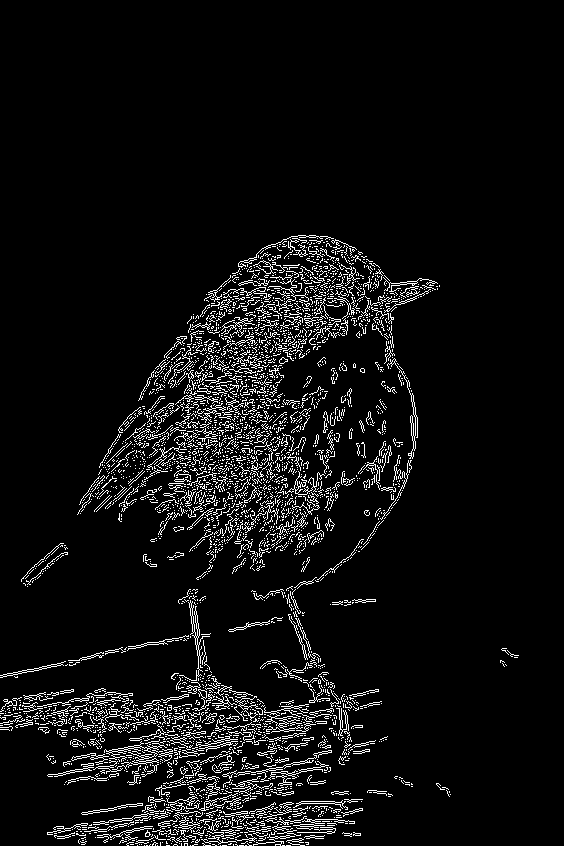

In [12]:
image

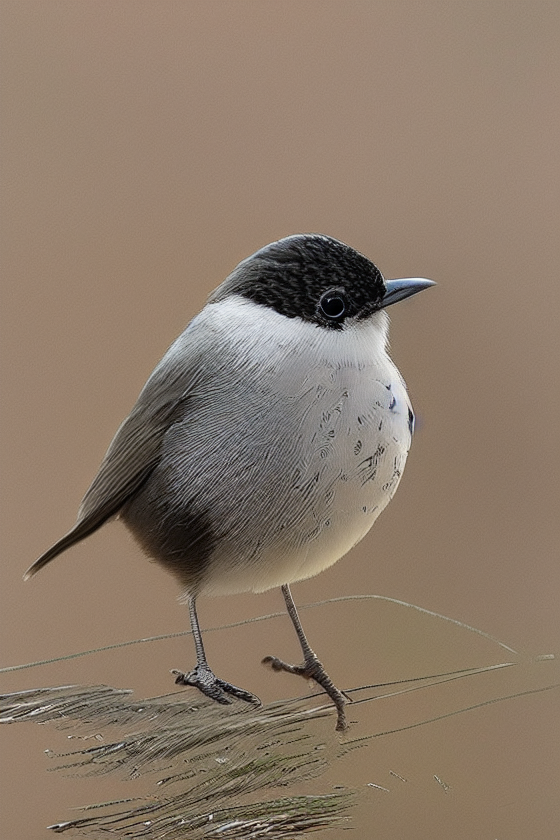

In [13]:
images

## Выводы

| Модель         | Тип       | Размер | Точность | Описание
|----------------|------------------------|----------|----------|----------|
| stable-diffusion-v1-5| text-to-image | 5 Gb   | ⭐⭐       | Отлично справляется с лицами, остальное плохо
| kandinsky-2-2-decoder | text-to-image | 10 Gb | ⭐⭐⭐ | Выглядит удовлетворительно, но даже в реализме мультяшно
| PixArt-XL-2-1024-MS | text-to-image | 22 Gb | ⭐⭐⭐⭐ | Большая, мощная, очень круто рисует мультики и средне реалистичные объекты (на то и art)
| openjourney-v4 | text-to-image | 5 Gb | ⭐⭐⭐ | Обученная на midjourney, низкая стоимость, плохо рисует мультики, но неплохо картинки с промптом к реализму
| Wan2.1-T2V-1.3B-Diffusers | text-to-video | 30 Gb | | Самое популярное решение на Hugging Face по категории, но тоже не хватило памяти
| LTX-Video | text-to-video| 30 Gb | | Популярная не очень тяжелая модель генерации видео по картинке или тексту. Но не для Colab...
| Open Sora v2 | text-to-video | 70 Gb | | Не хватает уже ПЗУ памяти, сама модель поместилась, но для окружения места не осталось(
| Git base by Microsoft | image-to-text | 700 Mb | ⭐⭐⭐ | Хорошо справляется с фото, но не понимает картинки (digital art)
| Blip Image by Salesforce | image-to-text | 800 Mb | ⭐⭐⭐⭐ | Хорошо справляется и с фото, и с картинками. Не видит детали, но в целом хорошо
| vit-gpt2-image-captioning | image-to-text | 700 Mb | ⭐⭐⭐ | Средне справляется как с фото, так и с картинками. Не хватает подробностей
| Donut base | image-to-text | 1 Gb | ⭐⭐ | Обычная классификация слабая, но есть возможности задавать вопросы к картинкам (не просто "что изображено?") и тут дела получше
| Stable-diffusion-XL | image-to-image | 4 Gb | ⭐⭐⭐ | Дообработка изображения, долго
| sd-controlnet-canny + sd15 | image-to-image | 5 Gb | ⭐⭐⭐⭐ | Берёт маску и "раскрашивает" картинку, через раз хорошая генерация